# Time-Dependent Global Sensitivity Analysis with Active Subspaces for a Lithium Ion Battery Model

__Paul Constantine__, Colorado School of Mines, <pconstan@mines.edu>

__Alireza Doostan__, University of Colorado Boulder

__Ryan Howard__, Colorado School of Mines, <ryhoward@mines.edu>

<br>

In this notebook, we'll be summarizing the active subspaces methodology and results on capacity and voltage of a lithium ion battery, presented in [[1]][R1].

### Introduction

Lithium (Li) batteries are the most popular batteries for small electronics, but their use is limited by their short lifespan and safety concerns. The scale on which these batteries must be analyzed ranges from overall cell thickness (millimeters) to the thickness of constituent particles (nanometers) and many physical phenomena are present, such as transport, mechanical, and electrochemical processes. Accurately modelling these systems is chellenging because there are often many input parameters whose exact values in practice are uncertain and simplifying assumptions must be made to make the complex physics tractable.

A method of addressing these challenges is _uncertainty quantification_ (UQ): using simulations to estimate the effects of our uncertainty about various aspects of our physical system. Traditional methods of UQ can be intractable with multiphysics models because the number of parameters required to charcterize the models tends to be large and the number of model evaluations to explore a system's behavior grows exponentially with the number of parameters. If a simulation is expensive, it may be impossible to run it enough times for an exhaustive parameter study. One approach to solving this 'curse of dimensionality' is to lower the dimension of the problem. In this notebook, we'll describe a method of dimension reduction called _active subspaces_ and its performance on a model of Li batteries.

### Active Subspaces

##### Stationary Models

In this framework, we consider our normalized uncertain parameters, $\mathbf x\in R^m$, as random variables with a joint pdf $\rho(\mathbf x)$. Our model has a (scalar) quantity of interest (output), $f$, that depends on the values of the parameters: $f = f(\mathbf x)$. The active subspaces methodology is based on the matrix

$$
\mathbf C = \int\nabla f(\mathbf x)\nabla f(\mathbf x)^T\rho(\mathbf x)\ d\mathbf x,
$$

where $\nabla f$ is the gradient of $f$ with respect to $\mathbf x$. This matrix is positive semidefinite, so it has an eigendecomposition:

$$
\mathbf C = \mathbf W\Lambda\mathbf W^T,\ \Lambda = \left[\begin{matrix}\lambda_1 & & \\ & \ddots & \\ & & \lambda_m\end{matrix}\right],\ \mathbf W = \left[\begin{matrix}\mathbf w_1 & \cdots & \mathbf w_m\end{matrix}\right],
$$

where the eigenvalues are in descending order. The eigenvalues satisfy the relationship $\lambda_i = \int(\nabla f^T\mathbf w_i)^2\rho\ d\mathbf x$. This means the $i^{th}$ eigenvalue is the average squared directional derivative of $f$ along $\mathbf w_i$; if an eigenvalue is relatively small, $f$ will be relatively flat in the direction defined by the corresponding eigenvector. If $\lambda_n > \lambda_{n+1}$ for some $n$, we can partition the decomposition as:

$$
\Lambda = \left[\begin{matrix}\Lambda_1 & \\ & \Lambda_2\end{matrix}\right],\ \mathbf W =  \left[\begin{matrix}\mathbf W_1 & \mathbf W_2\end{matrix}\right],
$$

where $\Lambda_1$ contians the first $n$ eigenvalues and $\mathbf W_1$ the corresponding vectors. If $\Lambda_2$'s eigenvalues are much smaller than those of $\Lambda_1$, then $f$ is likely relatively constant in the space spanned by $\mathbf W_2$ and we could approximate: $f(\mathbf x)\approx g(\mathbf W_1^T\mathbf x)$ with some $g:R^n\rightarrow R$. We call $\mathbf W_1^T\mathbf x \equiv \mathbf y$ the active variables and their range of values the active subspace.

Computing $\mathbf C$ analytically is generally impossible. If gradients are available, one can use a numerical integration rule to approximate $\mathbf C$ and its decomposition. Our model, however, does not give direct access to the gradient and it is too expensive to run for finite differences to be used to approximate gradients. A heuristic that can be used in such cases is based on a linear-model approximation of $f$: $f(\mathbf x) \approx a + \mathbf a^T\mathbf x \Rightarrow \nabla f \approx \mathbf a$. Then $\mathbf C \approx \int \mathbf a\mathbf a^T\rho(\mathbf x)\ d\mathbf x = \mathbf a\mathbf a^T = \mathbf w\lambda\mathbf w^T$, where $\lambda = ||\mathbf a||^2$ and $\mathbf w = \mathbf a/||\mathbf a||$. The purpose of this method is to identify $\mathbf w$ (the _single_ most important direction in the parameter space) rather than to approximate $f$; this method cannot identify higher-dimensional subspaces. We thus employ the algorithm: draw $\{\mathbf x_j\}_{j=1}^N$ from $\rho$ and compute $f_j = f(\mathbf x_j)\ \forall j$; compute the OLS estimates, $a^*$ and $\mathbf a^*$, of the linear model $f_j\approx a + \mathbf a^T\mathbf x_j$; and let $\mathbf w = \mathbf a^*/||\mathbf a^*||$.

We can easily see if we've found a 1-dimensional active subspace by creating a _summary plot_: a scatterplot of $\mathbf w^T\mathbf x_j$ vs $f_j$; if a tight univariate trend is present, we have likely discovered such a subspace. If the subspace is present, the components of $\mathbf w$ are a measure of global sensitivity; higher-magnitude components indicate relative sensitivity to the corresponding parameter. If the univariate trend is monotonic, the signs of components tell us whether increasing the corresponding parameter will increase or decrease output; for example, if the trend is monotonic increasing and a parameter has a positive component in $\mathbf w$, increasing it will increase the output.

##### Time-Dependent Models

Suppose our model's output depends on parameters, $\mathbf x$, and time, $t$: $f = f(\mathbf x, t)$. One way we could construct active subspaces on such a model is to extend $\mathbf C$ as

$$
\mathbf C = \frac 1 T\int\left(\int\left[\begin{matrix}f_t(\mathbf x, t)^2 & f_t(\mathbf x, t)\nabla f(\mathbf x, t)^T \\ f_t(\mathbf x, t)\nabla f(\mathbf x, t) & \nabla f(\mathbf x, t)\nabla f(\mathbf x, t)^T\end{matrix}\right]\rho(\mathbf x)\ d\mathbf x\right)\ dt,
$$

where $f_t(\mathbf x, t)$ is the partial derivative of $f$ with respect to $t$. This matrix has a block structure: $\mathbf C = \left[\begin{matrix}a & \mathbf b^T\\\mathbf b & \mathbf D\end{matrix}\right]$. We could construct subspaces based on the eigenvalues of the block $\mathbf D$, essentially averaging a time-dependent version of $\mathbf C$ from the above section, or we could use this new $\mathbf C$'s Schur compliment: $\mathbf C_S = \mathbf C - \frac 1 a\mathbf b\mathbf b^T$. However, the approach we choose to use is to treat the stationary-model $\mathbf C$ as a matrix whose elements depend on time:

$$
\mathbf C(t) = \int\nabla f(\mathbf x, t)\nabla f(\mathbf x, t)^T\rho(\mathbf x)\ d\mathbf x = \mathbf W(t)\Lambda(t)\mathbf W(t)^T.
$$

We can consider a discrete set of points in our time domain, $\{t_k\}_{k=1}^P$, and compute the eigendecomposition at each of these points to examine the time-dependence of the active subspace, or in our case, we can use the linear-model approximation algorithm at several points in time.

##### Assessing Uncertainty in the Active Subspace, and Limitations of Our Methods

We can assess variability in our estimate of $\mathbf w$ by examining the standard error of $\mathbf w$'s components acquired from a nonparametric bootstrap procedure. While the statistical interpretation of this method is absent since there is no random noise, high standard errors could still indicate that we don't have enough data to accurately estimate $\mathbf w$ or that a higher-dimensional subspace is required.

Estimating the active subspace is _extremely_ cheap in the sense that it can be done with far less than exhaustive sampling of the parameter space. However, this lack of exhaustive sampling can result in 'false positives' (our samples could erroneously indicate a subspace that actually doesn't exist) or 'false negatives' (our samples could be insufficient to find the subspace and make it appear that there is none). While these are possible, the relative smoothness of physical models with respect to their parameters makes it very unlikely that we would observe these cases in practice.

### The Lithium Battery Model

The model we use describes a Li battery as a cathode and an anode separated by a separator. Electrical current is produced when Li$^+$ ions diffuse from the anode to the cathode through the separator and electrons flow through the external circuit, again from anode to cathode. We examine two quantities of interest outputted by the model: capacity as a function of voltage (voltage plays the role of time in the above discussion
) and voltage as a function of time. The model has 19 input parameters, summarized in the table below.

Variable Name | Symbol | Distribution $\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $
:-------------|:------:|:------------
Anode Porosity | $\epsilon_a$ | $U(0.46, 0.51)$    
Anode Bruggeman Coefficient | brugg$_a$ | $U(3.8, 4.2)$
Anode Solid Diffusion Coefficient | $D_{s, a}$ | $U(3.51, 4.29)\times 10^{-14}$
Anode Conductivity | $\sigma_a$ | $U(90, 110)$
Anode Reaction Rate | $k_a$ | $U(4.52, 5.53)\times 10^{-11}$
Anode Particle Size | $r_{s, a}$ | $N(2, 0.1354$
Anode Length | $L_a$ | $U(77, 83)$
Cathode Porosity | $\epsilon_c$ | $U(0.36, 0.41)$    
Cathode Bruggeman Coefficient | brugg$_c$ | $U(3.8, 4.2)$
Cathode Solid Diffusion Coefficient | $D_{s, c}$ | $U(0.90, 1.10)\times 10^{-14}$
Cathode Conductivity | $\sigma_c$ | $U(90, 110)$
Cathode Reaction Rate | $k_c$ | $U(2.10, 2.56)\times 10^{-11}$
Cathode Particle Size | $r_{s, c}$ | $N(2, 0.3896$
Cathode Length | $L_c$ | $U(85, 91)$
Separator Porosity | $\epsilon_s$ | $U(0.63, 0.81)$    
Separator Bruggeman Coefficient | brugg$_s$ | $U(3.2, 4.8)$
Separator Length | $L_s$ | $U(22, 28)$
Li$^+$ Transference Number | $t_+^0$ | $U(0.345, 0.381)$
Salt Diffusion Coefficient in Liquid | $D$ | $U(6.75, 8.25)\times 10^{-10}$

We examine our quantities of interest at three discharge rates: $0.25C, 1C$, and $4C$, where $C$ is the rate at which a battery discharges from its full capacity. Our dataset has 3600 pairs of inputs/outputs for each discharge rate (very sparse for a 19-dimensional input space), totaling 10800 runs. The outputs are 50 voltage/capacity and 50 time/voltage pairs. The inputs were drawn according to the distributions above, but our analysis scales them to the hypercube $[-1,1]^{19}$, and we reparameterize time: we let $t^* = 100$ at physical time 0 and $t^* = 0$ at the physical time when voltage reaches $2.8V$ (this is when the simulations are ended).

### References:

[[1]][R1] P.G. Constantine and A. Doostan. _Time-dependent global sensitivity analysis with active subspaces for a lithium ion battery model_. arXiv:1606.08770

[[2]][R2] P.G. Constantine, E. Dow, and Q. Wang. _Active subspaces in theory and practice: applications to kriging surfaces_. SIAM J. Sci. Comput., 36(4), A1500–A1524

[[3]][R3] P.G. Constantine. _Active Subspaces: Emerging Ideas for Dimension Reduction in Parameter Studies_. SIAM, 2015. ISBN: 978-1-611973-85-3

[R1]: https://arxiv.org/abs/1606.08770
[R2]: http://dx.doi.org/10.1137/130916138
[R3]: http://bookstore.siam.org/sl02/

<br>

### Demonstration and Discussion

We'll now reproduce the figures from [[1]][R1] and discuss their implications. The code used to generate the figures is contained in the file 'battery_figs.py', which can be found in the github repository. We'll first examine capacity as a function of voltage.

In [1]:
%matplotlib inline
from battery_figs import *
import matplotlib.pyplot as plt

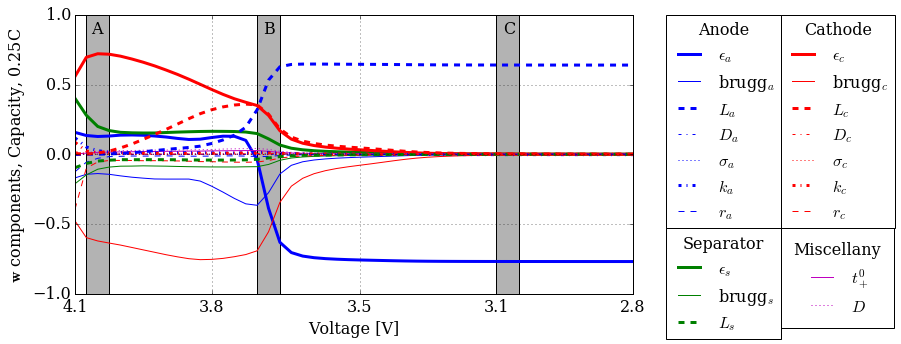

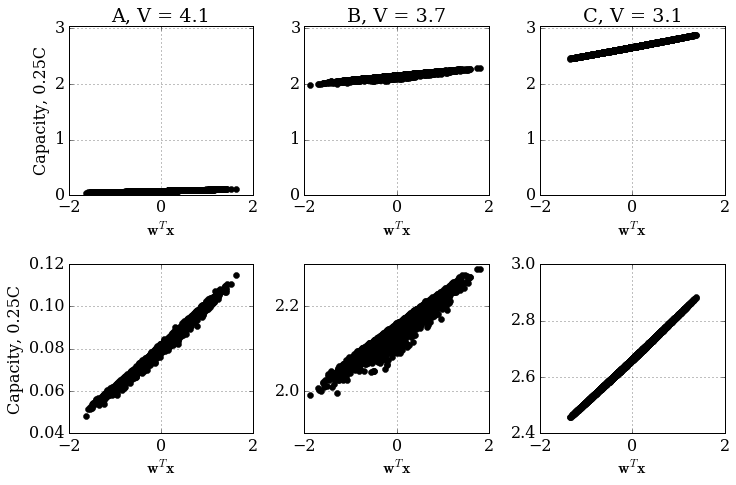

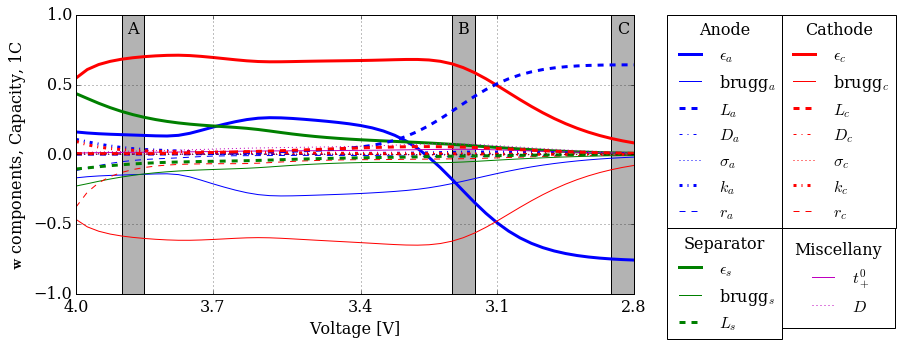

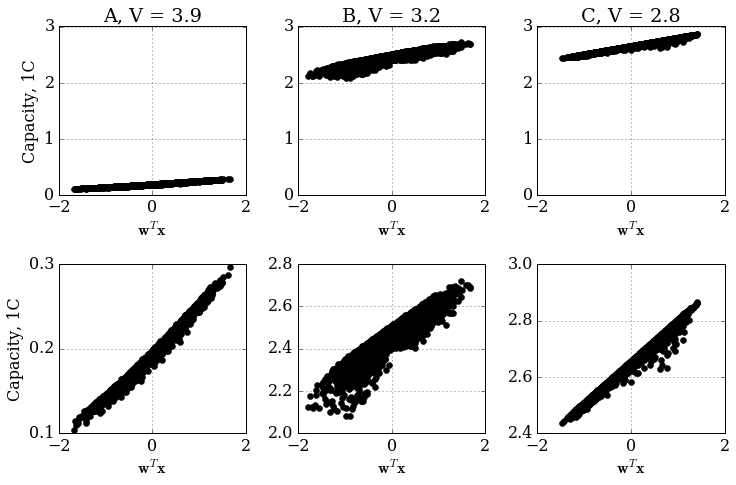

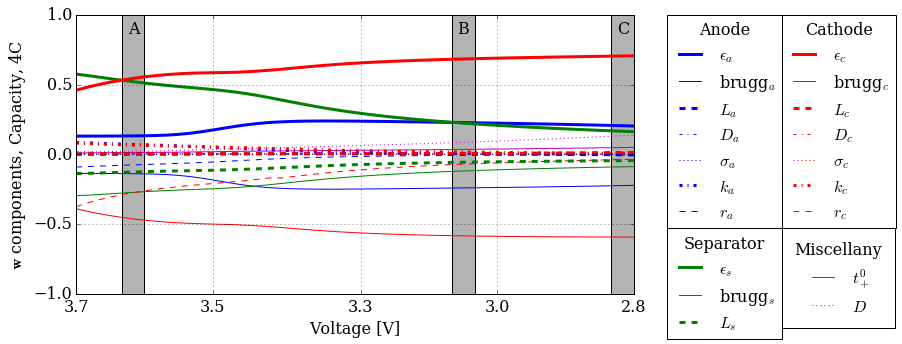

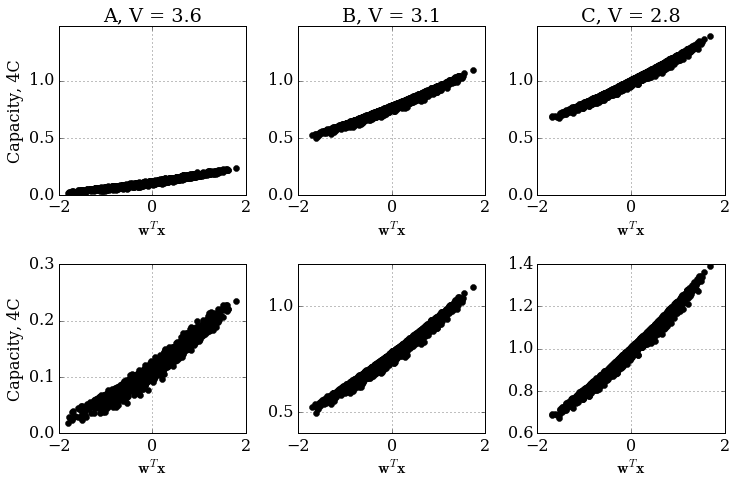

In [2]:
Cap_025C()
Cap_1C()
Cap_4C()

Each discharge rate has a plot showing the evolution of the coefficients of $\mathbf w$ as voltage changes; the graphs below these are the summary plots, with the active variable $\mathbf w^T\mathbf x$ on the $x$-axis and our data values on the $y$-axis, each corresponding to the voltages labeled A, B, and C. The top row of summary plots for each discharge rate all have the same values on the $y$-axis, demonstrating the variation of capacity as voltage decreases; the bottom row shows the exact same data, but zoomed in to elucidate the trends of capacity as functions of the active variable.

Each summary plot shows at least a fairly tight trend, though variation around the trend varies by discharge rate and voltage. The tightest trend appears for discharge rate $0.25C$ and voltage $3.1V$ and the loosest for $1C$ and $3.2V$. The trends appear to be loose in regions where the relative importance of parameters is shifting rapidly; outside of these regions (all voltages for $4C$ and extreme voltages for $1C$ and $0.25C$), capacity is well approximated by a univariate function of the active variable. Two interesting observations of these graphs are that most of the parameters have components close to 0, indicating that they are unimportant in characterizing capacity, and that changes in the relative importance of parameters occur more smoothly as the discharge rate increases.

We'll now create similar plots for voltage as a function of time.

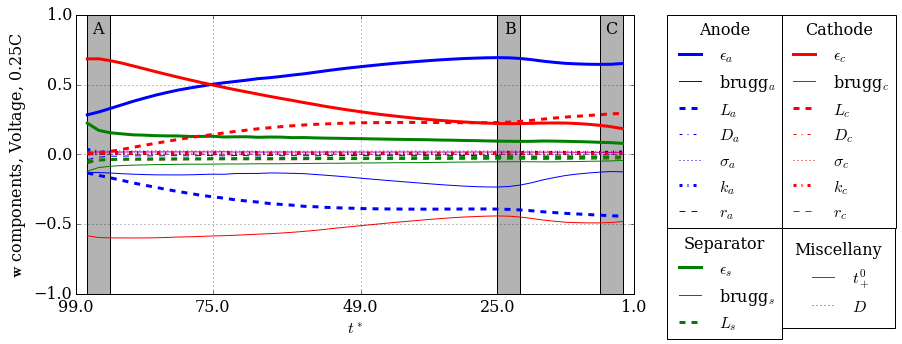

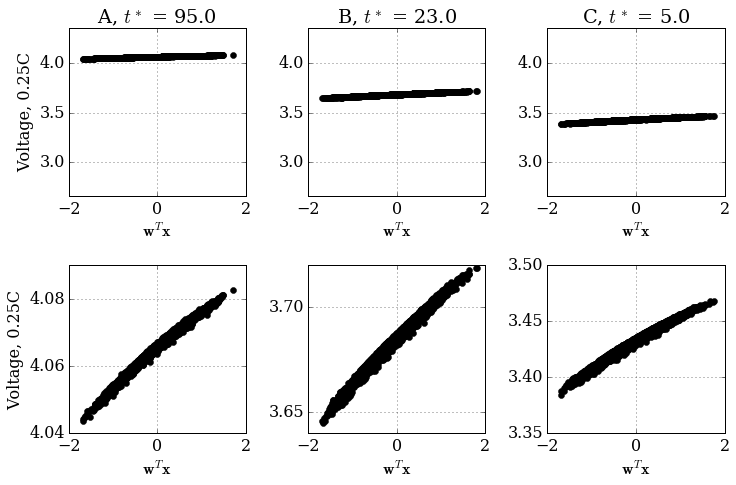

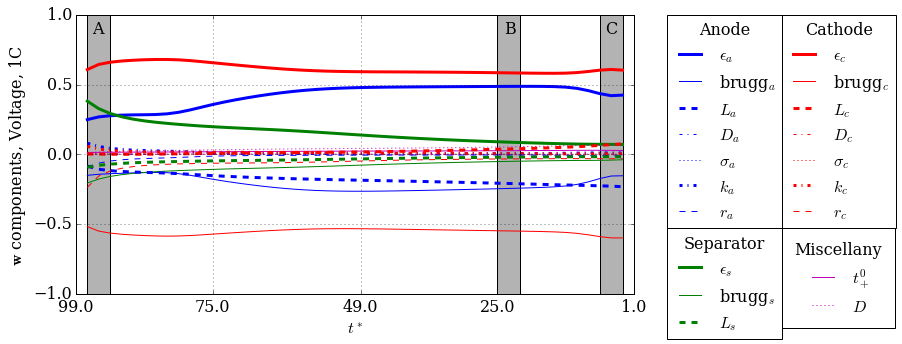

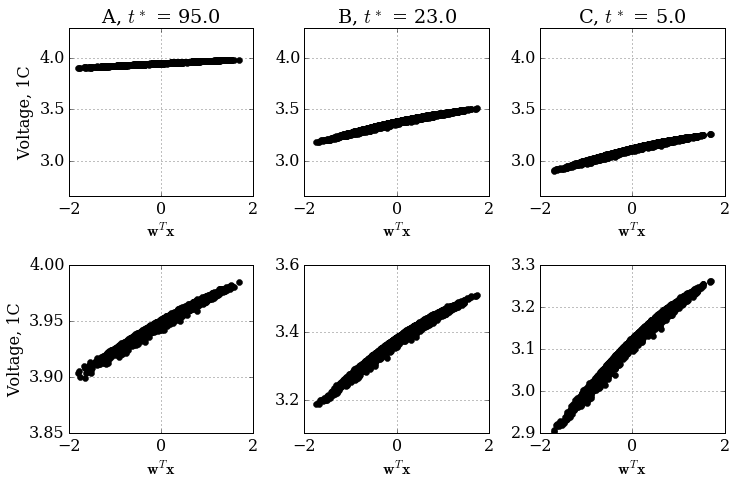

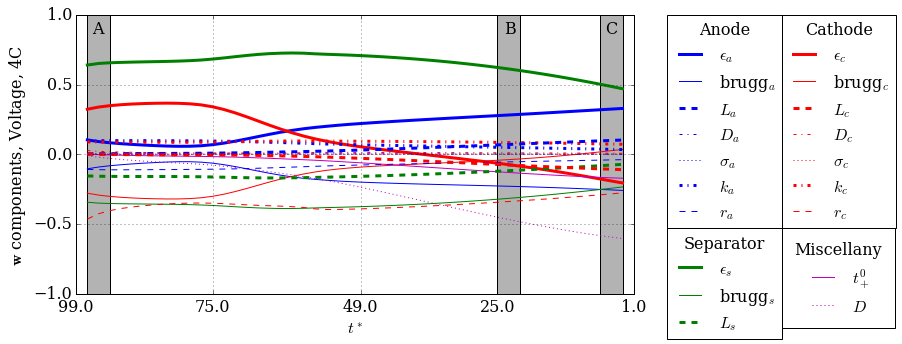

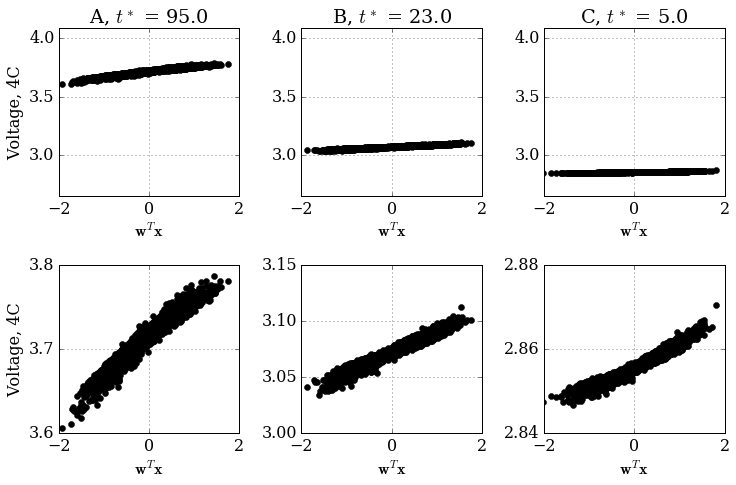

In [3]:
Vol_025C()
Vol_1C()
Vol_4C()

We can see that every trend here is tight enough that voltage can reasonably be approximated as a univariate function of the active variable, and that relative sensitivities are much less sensitive to time compared to capacity with voltage. More parameters are important (have coefficients far from 0) for approximating voltage, and for a discharge rate of $4C$, the salt diffusion coefficient becomes important as $t^*$ decreases (physical time increases); this is the only time we see significant impact of a diffusion parameter. In all cases (for both capacity and voltage and all discharge rates), porosities, lengths, and bruggeman coefficients remain the most important parameters in characterizing output.

Lastly, we'll plot bootstrap standard errors (as a function of voltage for capacity and as a function of time for voltage) to examine the robustness of our method.

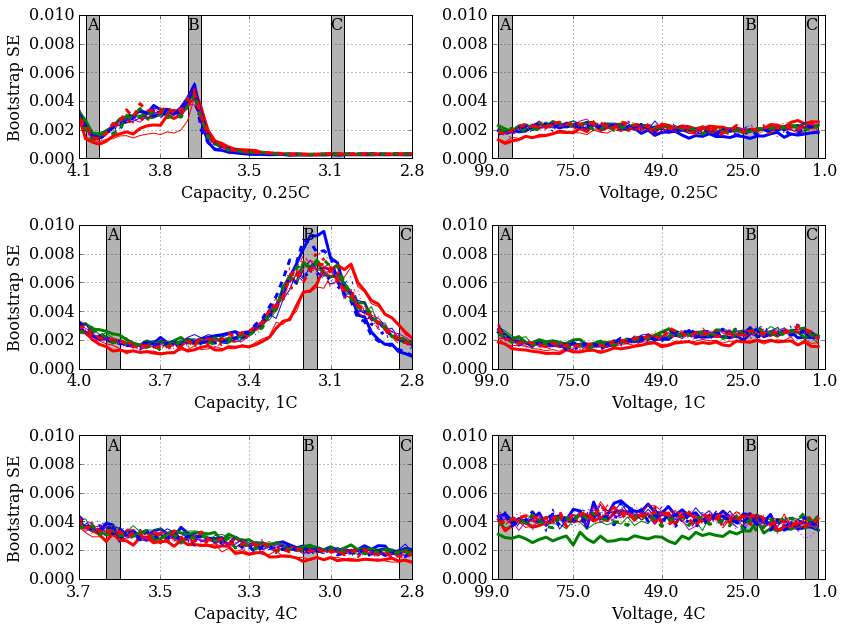

In [4]:
bootstrap_SE()

All bootstrap errors are fairly low (all are below 0.010 and most are below 0.005), indicating that the estimated components would likely not change much if the sampled points happened to be different. However, there are 2 notable spikes in standard error: region B for both capacity with $0.25C$ and capacity with $1C$. These correspond to the loose trends in the summary plots and points where the relative sensitivities of parameters are shifting rapidly. These could be caused by regime changes in the physical system that cause behavior that either can't be captured by our linear-model heuristic or can't be captured by a 1-dimensional subspace.